<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/MNIST_Perturbation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of Analyzers using Input Perturbations

This notebook will guide you through an example of how to evaluate analyzers via perturbing the input according to the importance that the analysis method attribute to input regions.

The input images are divided into quadratic regions that are sorted according to their importance w.r.t. to the pixel-wise saliency scores assigned by those analyzers. Then, the information content of the image is gradually destroyed by perturbation of the most important regions. The effect of this perturbation on the classifier performance is measured. This procedure is repeated several times.

We expect that the classifier performance drops quickly if important information is removed and remains largely unaffected when perturbing unimportant regions.

Thus, different analyzers can be compared by measuring how quickly their performance drops, i.e. the quicker the classifier performance drops after input perturbation w.r.t. to the prediction analysis, the better the analyzer is capable of identifying the input components responsible for the output of the model.

Similarly, several models can be compared, e.g. with random perturbations on the data, towards their resilience to noisy input data: The faster the model prediction declines with ongoing perturbations, the more susceptible the classifier is to noise.

Reference:

*[Samek et al.](http://dx.doi.org/10.1109/TNNLS.2016.2599820)*, "Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

-----

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

# **Import needed libraries**


In [9]:
!pip install -q git+https://github.com/albermax/innvestigate
!pip install -q deeplift
!git clone https://github.com/infomon/understanding_cnn
import shutil
shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
shutil.move("/content/understanding_cnn/models/pretrained_models/MNISTcnn.h5", "/content")
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 54 (delta 12), reused 42 (delta 5), pack-reused 0
Unpacking objects: 100% (54/54), done.


# Imports

In [10]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
%matplotlib inline  

import imp
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils

from innvestigate.tools import Perturbation, PerturbationAnalysis

try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle
    
import json

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")

# Data
Then, the MNIST data is loaded in its entirety, formatted according to the specifications of the Keras backend.

In [12]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

x_test, y_test = data[2:]
y_test = keras.utils.to_categorical(y_test, num_classes)
test_sample = np.copy(x_test[0:1])
generator = iutils.BatchSequence([x_test, y_test], batch_size=256)

11493376/11490434 [==============================] - 2s 0us/step


# Model

The next part trains and evaluates a CNN.

In [13]:
# Create & train model
model = keras.models.load_model('MNISTcnn.h5')
model.get_layer(name='dense_1').name = 'dense_1a'
model.get_layer(name='conv2d_1').name = 'conv2d_1a'
model.get_layer(name='conv2d_2').name = 'conv2d_2a'

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `regions_per_step`: In each perturbation step, the `regions_per_step` regions are perturbed.

Feel free to play around with different analyzers, e.g. by selecting them from the `methods` list via `selected_methods_indices`.

## 1. Evaluate the model after several perturbation steps

In [14]:
perturbation_function = "gaussian"
region_shape  = (7, 7) 
steps = 15
regions_per_step = 1  # Perturbate 1 region per step

# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE
    ("random",{},mnistutils.graymap,"Random"), #0
    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"), #1

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,        "Gradient"), #2
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},mnistutils.graymap,        "SmoothGrad"), #3

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"), #4
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",), #5
    ("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"), #6

    # Interaction
    ("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"), #7
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"), #8
    ("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"), #9
    ("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"), #10
    ("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"), #11
    ("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
                                                        mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"), #12
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"), #13
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"), #14
    ("lrp.epsilon_IB",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"), #14
    ("lrp.alpha_1_beta_0",           {},           mnistutils.heatmap,        "LRP-Alpha1-Beta0"), #15
    ("lrp.alpha_1_beta_0_IB",           {},           mnistutils.heatmap,        "LRP-Alpha1-Beta0 IB"), #16
    ("lrp.alpha_2_beta_1",           {},           mnistutils.heatmap,        "LRP-Alpha2-Beta1"), #17
    ("lrp.alpha_2_beta_1_IB",           {},           mnistutils.heatmap,        "LRP-Alpha2-Beta1 IB"), #18
]

# Select methods of your choice
selected_methods_indices = [0,14,15,16,17,18,19]
selected_methods = [methods[i] for i in selected_methods_indices]
print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))

Using method(s) "['random', 'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB']".


The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [0]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

analyzers = [innvestigate.create_analyzer(method[0],
                                        model_wo_softmax,
                                        **method[1]) for method in selected_methods]
for analyzer in analyzers:
    analyzer.fit(data[0],
                 batch_size=1, verbose=1)

### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (2, 2)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 1% most important pixels are perturbed.

In [16]:
scores_selected_methods = dict()
perturbation_analyses = list()
for method, analyzer in zip(selected_methods, analyzers):
    print("Method: {}".format(method[0]))
    
    # Set up the perturbation analysis
    perturbation = Perturbation(perturbation_function, region_shape=region_shape, in_place=False)
    
    # Comment out to invert the perturbation order
    # perturbation.aggregation_function = lambda x, axis: -np.mean(x, axis=axis)
    
    perturbation_analysis = PerturbationAnalysis(analyzer, model, generator, perturbation, recompute_analysis=False,
                                                steps=steps, regions_per_step=regions_per_step, verbose=True)
    
    scores = perturbation_analysis.compute_perturbation_analysis()
    
    # Store the scores and perturbation analyses for later use
    scores_selected_methods[method[0]] = np.array(scores)
    perturbation_analyses.append(perturbation_analysis)
    print()

Method: random
Step 1 of 15: 1 regions perturbed. Time elapsed: 0.806 seconds.
Step 2 of 15: 2 regions perturbed. Time elapsed: 1.004 seconds.
Step 3 of 15: 3 regions perturbed. Time elapsed: 1.004 seconds.
Step 4 of 15: 4 regions perturbed. Time elapsed: 1.104 seconds.
Step 5 of 15: 5 regions perturbed. Time elapsed: 1.204 seconds.
Step 6 of 15: 6 regions perturbed. Time elapsed: 1.410 seconds.
Step 7 of 15: 7 regions perturbed. Time elapsed: 1.404 seconds.
Step 8 of 15: 8 regions perturbed. Time elapsed: 1.505 seconds.
Step 9 of 15: 9 regions perturbed. Time elapsed: 1.506 seconds.
Step 10 of 15: 10 regions perturbed. Time elapsed: 1.614 seconds.
Step 11 of 15: 11 regions perturbed. Time elapsed: 1.605 seconds.
Step 12 of 15: 12 regions perturbed. Time elapsed: 1.805 seconds.
Step 13 of 15: 13 regions perturbed. Time elapsed: 1.806 seconds.
Step 14 of 15: 14 regions perturbed. Time elapsed: 1.906 seconds.
Step 15 of 15: 15 regions perturbed. Time elapsed: 1.905 seconds.
Time elapsed 

Plot the perturbation curves and compute area over the perturbation curve (AOPC)

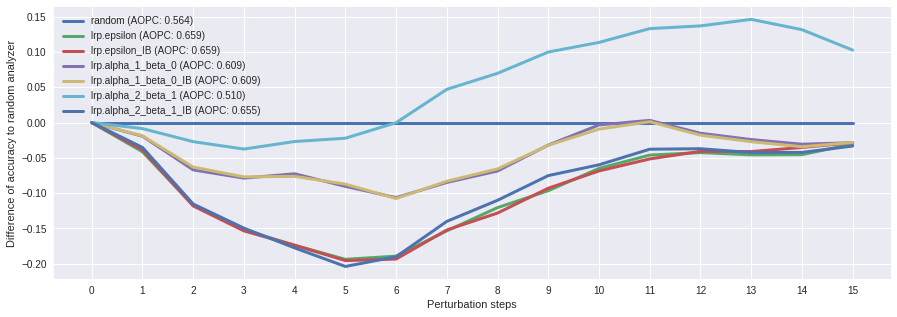

In [17]:
#np.save("scores_selected_methods",scores_selected_methods)
with open('scores_selected_methods.p', 'wb') as fp:
    pickle.dump(scores_selected_methods, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('scores_selected_methods.json', 'w') as fp:
#    json.dump(scores_selected_methods, fp, sort_keys=True, indent=4)

fig = plt.figure(figsize=(15, 5))
linestyles = ['-', '--', '-.', ':']
linestye_counter = 0
aopc = list()  # Area over the perturbation curve
baseline_accuracy = scores_selected_methods["random"][:, 1]
for method_name in scores_selected_methods.keys():
    scores = scores_selected_methods[method_name]
    accuracy = scores[:, 1]
    aopc.append(accuracy[0] - np.mean(accuracy))
    
    label = "{} (AOPC: {:.3f})".format(method_name, aopc[-1])
    plt.plot(accuracy - baseline_accuracy, label=label,
             linestyle=linestyles[linestye_counter],
             linewidth=3)
    
plt.xlabel("Perturbation steps")
plt.ylabel("Difference of accuracy to random analyzer")
plt.xticks(np.array(range(scores.shape[0])))
plt.legend()
plt.show()

As mentioned above, a steeper decrease shows a better identification of the relevant information.

## 2. Plot perturbed sample
Finally, we plot the perturbations on a selected test sample and show them along with the respective analyses.

<Figure size 432x288 with 0 Axes>

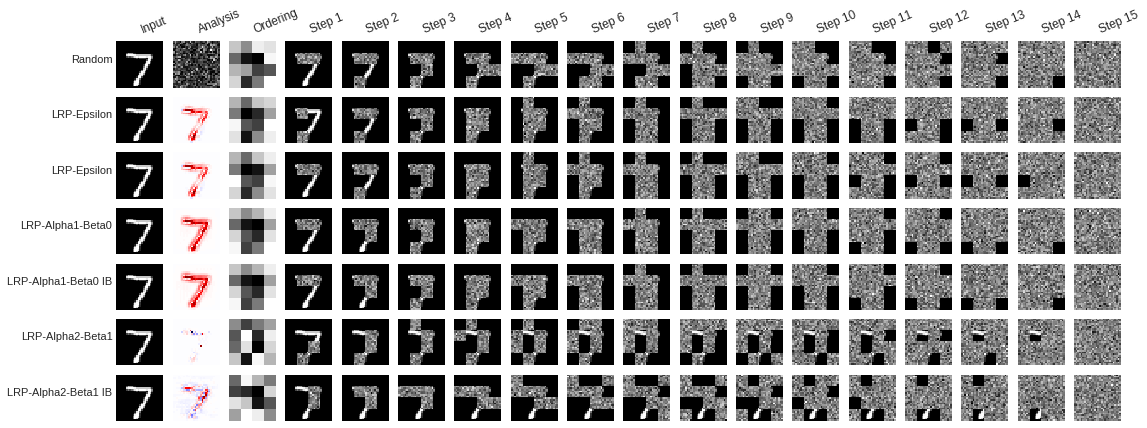

In [18]:
# Now plot the perturbation step by step.
fig1 = plt.figure()
fig1 = plt.gcf()
grid, row_labels = [], []
col_labels = ["Input", "Analysis", "Ordering"]+["Step {}".format(i+1) for i in range(steps)]


for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    row_labels.append([method[-1]])
    samples = list()
    
    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.num_perturbed_regions = 1

    sample = test_sample
    analysis = perturbation_analysis.analyzer.analyze(sample)

    # Divide into regions and order them according to their analysis score
    # TODO backend channel ordering
    aggregated_regions = perturbation_analysis.perturbation.reduce_function(np.moveaxis(analysis, 3, 1), axis=1, keepdims=True)
    aggregated_regions = perturbation_analysis.perturbation.aggregate_regions(aggregated_regions)
    ranks = perturbation_analysis.perturbation.compute_region_ordering(aggregated_regions)

    # Perturbate for some steps
    for i in range(steps+1):
        # Plot the original image and analysis without any perturbation
        if i > 0:
            perturbation_analysis.perturbation.num_perturbed_regions += perturbation_analysis.regions_per_step
            # Perturbate
            sample = perturbation_analysis.compute_on_batch(sample, analysis)
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        sample_to_show = mnistutils.postprocess(sample.repeat(3, axis=-1))
        analysis = mnistutils.postprocess(analysis)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        sample_to_show = np.clip(input_postprocessing(sample_to_show), 0, 1)

        samples.append(sample_to_show[0])    
    # Plot analysis
    analysis = method[2](analysis)
    
    # Add analysis and ranking
    samples.insert(1, analysis[0])
    samples.insert(2, -ranks[0][0])
        
    grid.append(samples)
  
eutils.plot_image_grid(grid, row_labels, list(), col_labels)
plt.show()

fig1.savefig('selectivityImgGradients.png', bbox_inches='tight')